# مدل آیزینگ

In [1]:
import numpy as np
from scipy.ndimage import convolve
N = 10

class IsingModel(np.ndarray):
    def __new__(cls , N , *args , **kwargs ):
        obj = np.random.choice([1 , -1] , size=[N,N] ).view(cls)
        return obj

    def __array_finalize__(self , obj):
        if obj is None: return

    def __init__(self , N):
        self.N = N
        self._filter = np.array([[0, 1, 0], [1, 0, 1], [0, 1, 0]])
        self._neighbors = convolve(self , self.filter , mode='wrap')

    @property
    def magnetization(self):
        return float(np.sum(self))

    @property
    def filter(self):
        return self._filter

    @property
    def neighbors(self):
        return self._neighbors

    @property
    def energy(self):
        return float(-0.5*np.sum( self*self.neighbors ))

    def monte_carlo_step(self, temperature : float ) -> bool:
        """
            Perform a single Monte Carlo sweep with sequential spin updates.
            Returns the number of accepted spin flips.    
        """
        i = np.random.randint(0, self.N-1)
        j = np.random.randint(0, self.N-1)

        # Calculate the energy change if this spin is flipped
        delta_E = 2 * self[i, j] * self.neighbors[i, j]
        # Apply Metropolis criterion
        if delta_E <= 0 or np.random.rand() < np.exp(-delta_E / temperature):
            self[i, j] *= -1  # Flip the spin
            # Update the n_sum matrix around the (i, j) element
            self._neighbors[ i+1 % self.N , j] += 2 * self[i, j]
            self._neighbors[ i-1 , j] += 2 * self[i, j]
            self._neighbors[ i , j+1 % self.N] += 2 * self[i, j]
            self._neighbors[ i , j-1] += 2 * self[i, j]
            return True
        return False


In [ ]:
from matplotlib import pyplot as plt
import numpy as np
from concurrent.futures import ThreadPoolExecutor 


def simulate_ising_model(T , N=5 , steps_to_equilibrium = 2000 , steps_to_average = 10000):
    E, M, A = np.zeros(steps_to_average), np.zeros(steps_to_average), np.zeros(steps_to_average)
    E_ = np.zeros(steps_to_equilibrium) 
    model = IsingModel(N)
    for i in range(steps_to_equilibrium):
        model.monte_carlo_step(T)
        E_[i] = model.energy


    for i in range(steps_to_average):
        res = model.monte_carlo_step(T)
        E[i] = model.energy
        M[i] = model.magnetization
        A[i] = res
    return T, E_ , E , M , A

temperatures = np.linspace(0.1, 4.1, 10)
N_Simulations = 20
allResults = []
with ThreadPoolExecutor() as executor:
    results = list(executor.map(simulate_ising_model, np.repeat(temperatures, N_Simulations) ))
    allResults.append(results)


/tmp/ipykernel_38412/3429467519.py:19: RuntimeWarning: overflow encountered in exp
  hf /= np.exp( -b[:-1] / T)
/tmp/ipykernel_38412/3429467519.py:19: RuntimeWarning: invalid value encountered in divide
  hf /= np.exp( -b[:-1] / T)


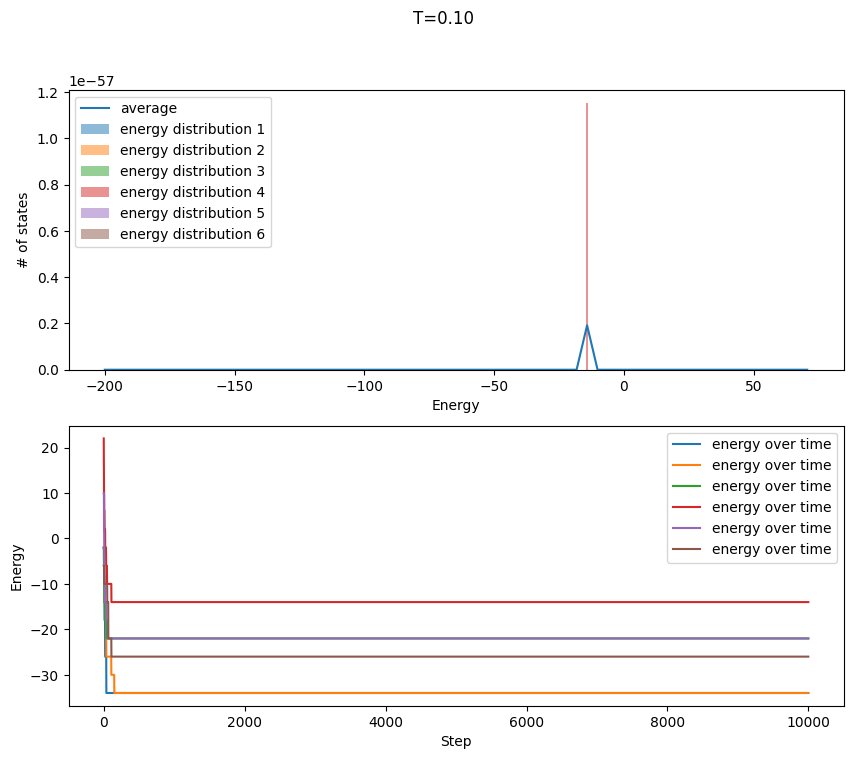

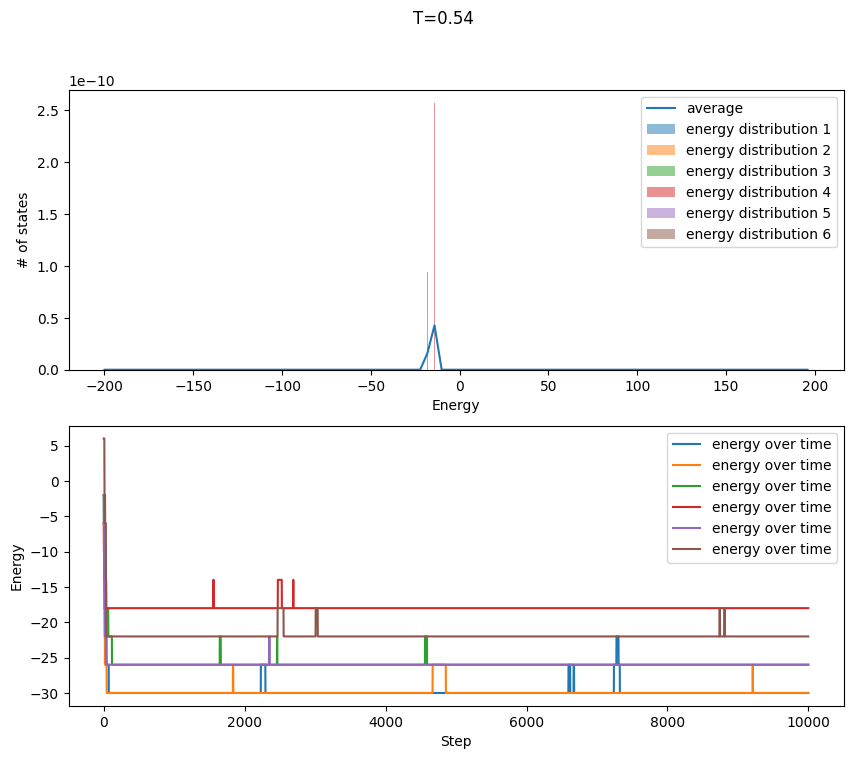

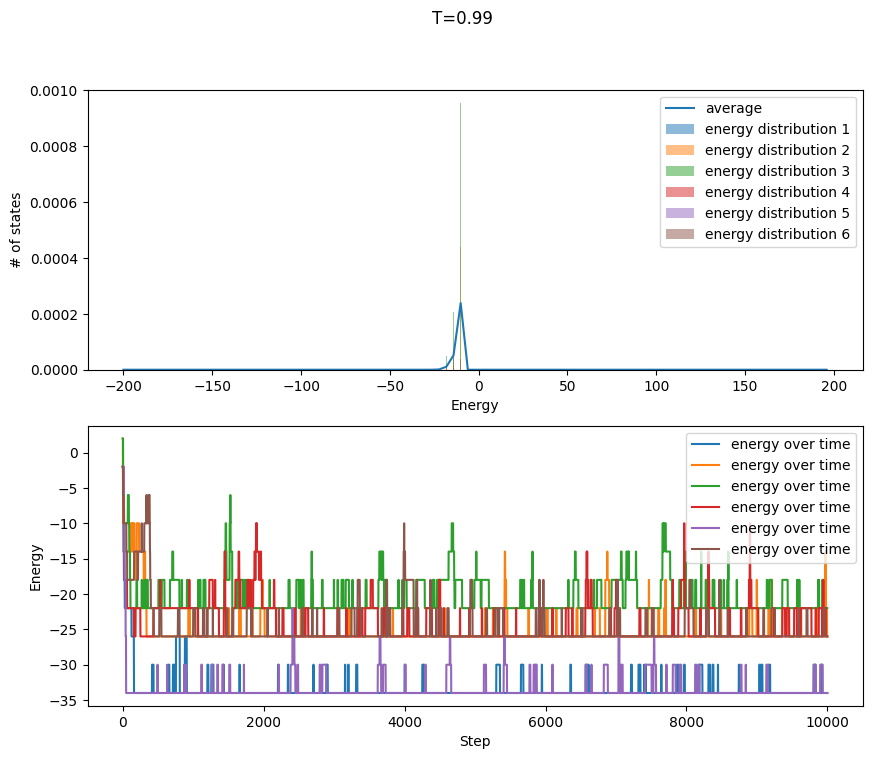

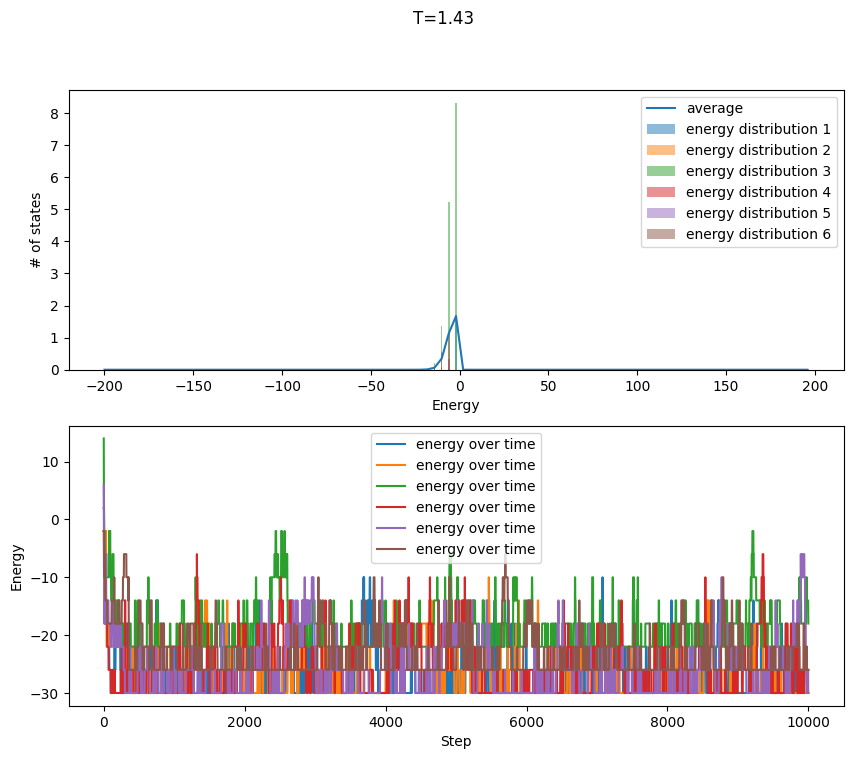

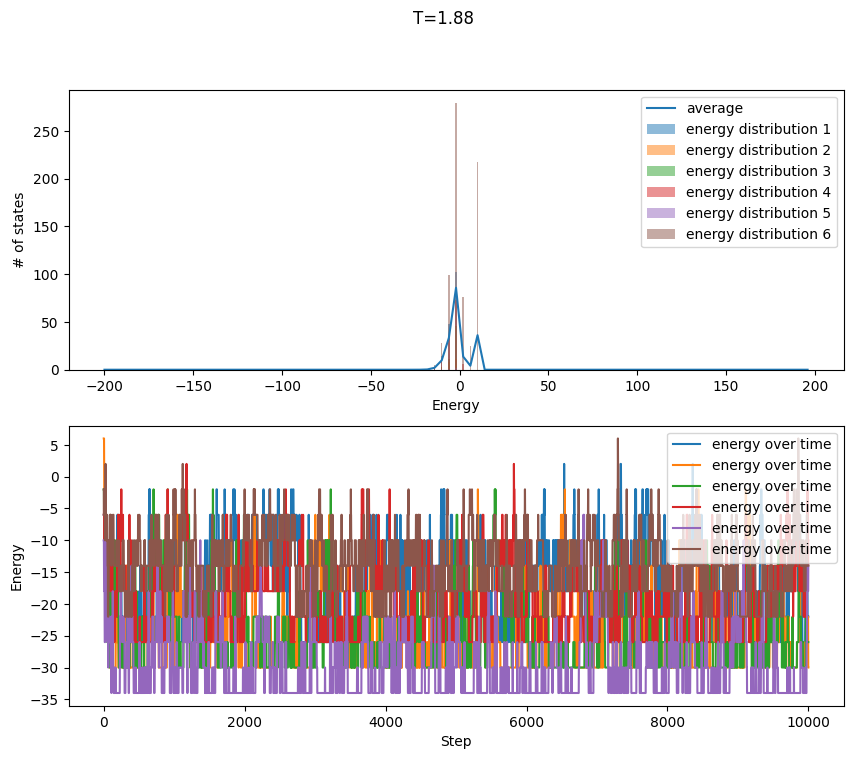

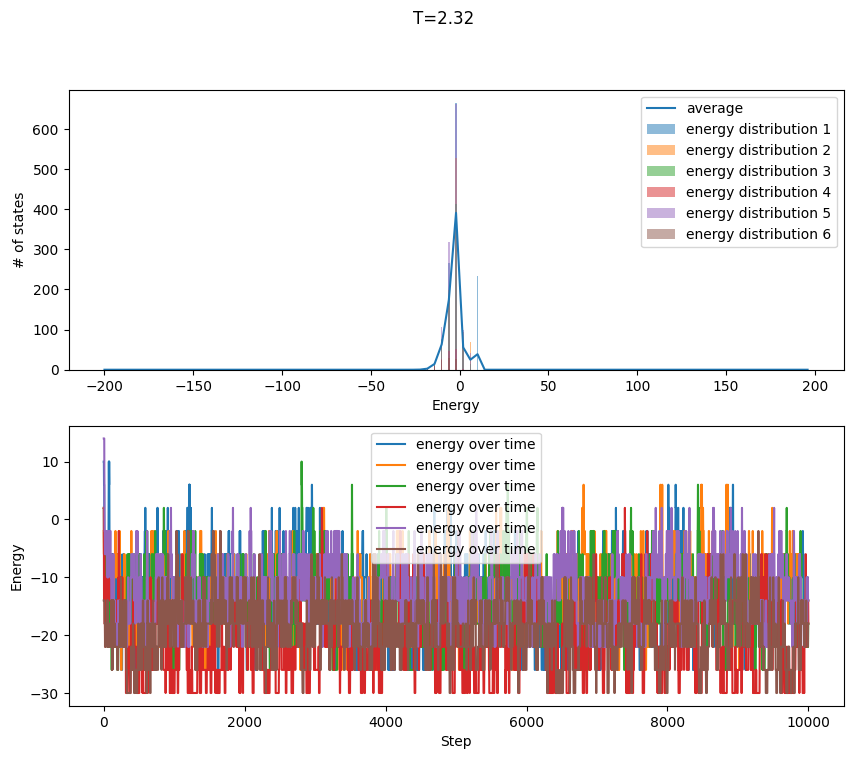

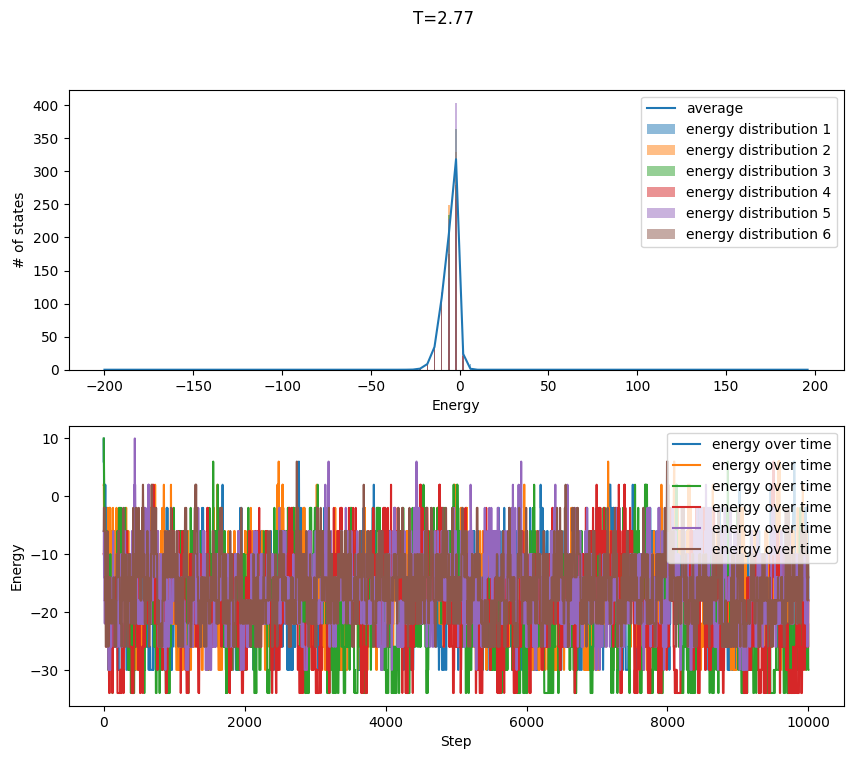

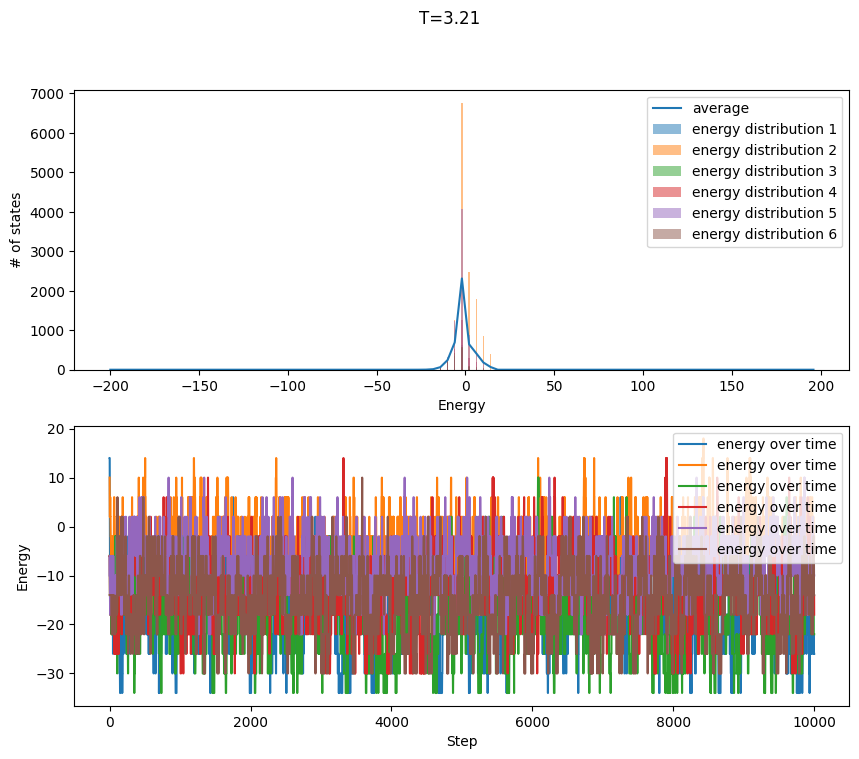

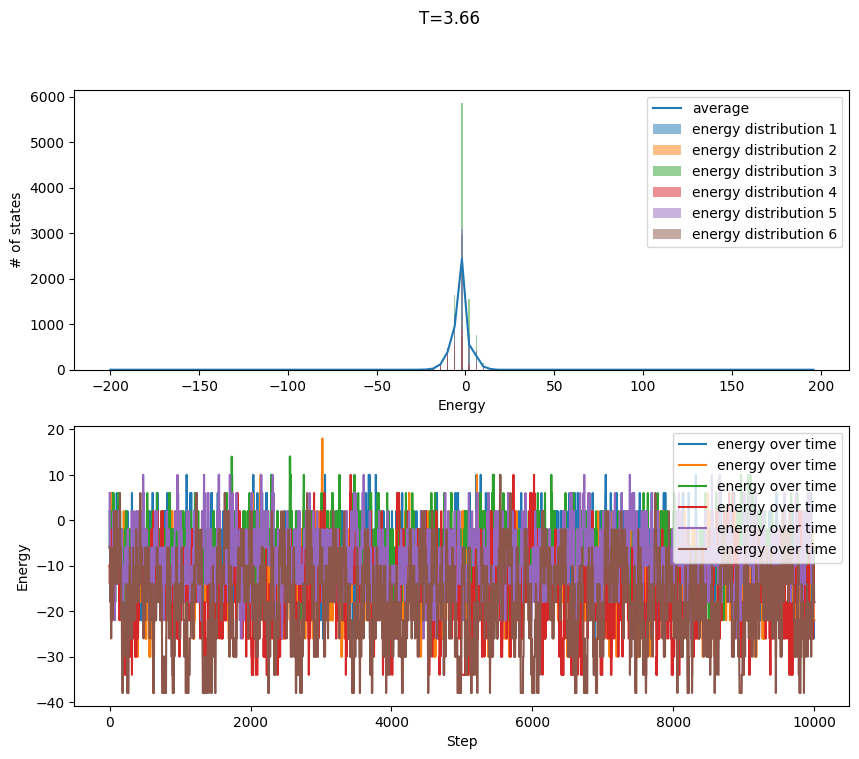

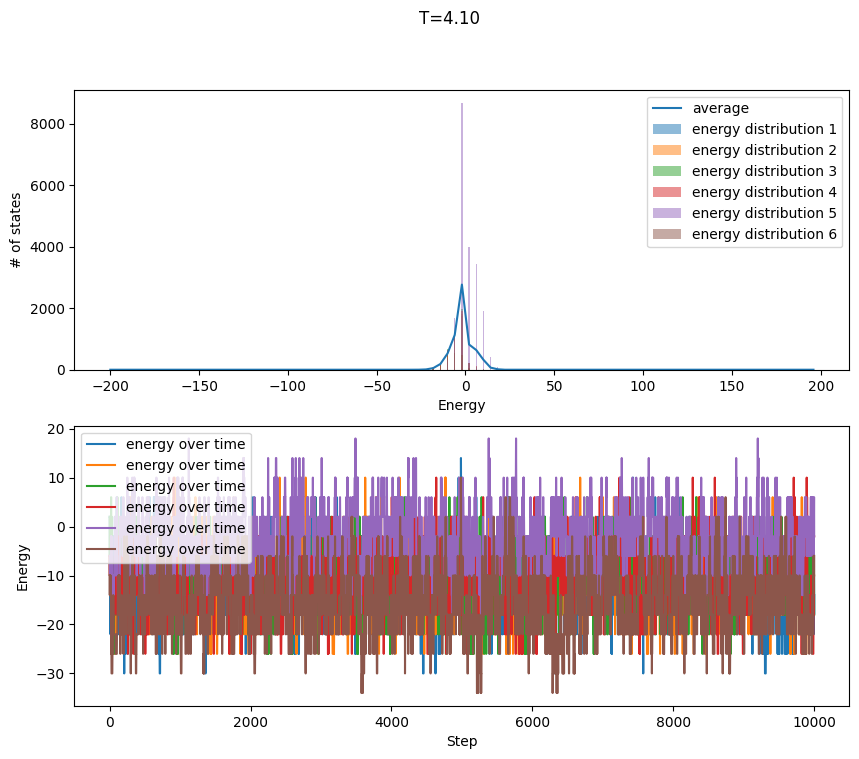

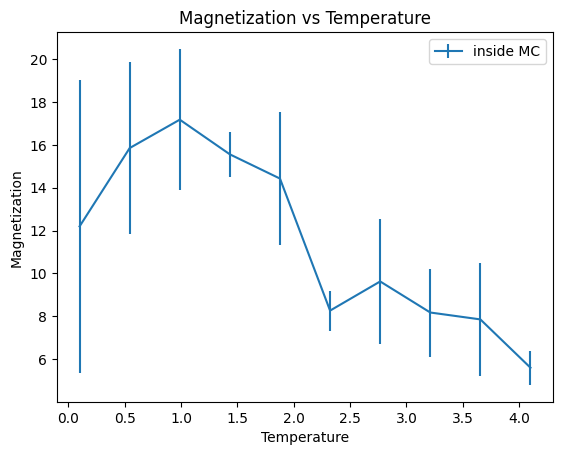

In [ ]:
M_avg = []
M_stdev = []

e_bins = np.linspace(-2*N**2 , 2*N**2 , 100)
for T in temperatures:
    res = [ r for r in allResults if r[0] == T ]
    Es_ = [ r[1] for r in res ]
    Es = [ r[2] for r in res ]
    Ms = [ r[3] for r in res ]
    As = [ r[4] for r in res ]

    fig, axs = plt.subplots(2, 1, sharex=False, figsize=(10, 8))
    fig.suptitle(f"T={T:.2f}")
    def ehist(E, T):
        h , b = np.histogram(E , bins=e_bins)
        hf = h.astype(float )
        hf /= np.exp( -b[:-1] / T)
        return hf
    for i, E in enumerate(Es):
        axs[0].bar( e_bins[:-1] , ehist(E , T) , label=f'energy distribution {i}' , alpha=0.5)
    axs[0].plot( e_bins[:-1] , ehist( np.concatenate(Es) , T )/N_Simulations , label='average')
    axs[0].set_ylabel("# of states")
    axs[0].set_xlabel("Energy")
    axs[0].legend()
    
    for i, E_ in enumerate(Es_):
        axs[1].plot(E_, label=f'energy over time {i}' , alpha=0.5)
    axs[1].set_ylabel("Energy")
    axs[1].set_xlabel("Step")
    axs[1].legend()
    
    plt.show()
    M_vals = [ np.mean( np.abs( M[::1] ) ) for M in Ms ]
    M_avg.append( np.mean(M_vals) )
    M_stdev.append( np.std(M_vals) )
    
#now plot magnetization with error bars 
plt.errorbar(temperatures, M_avg , yerr=M_stdev , label="inside MC")
plt.legend()
plt.title("Magnetization vs Temperature")
plt.xlabel("Temperature")
plt.ylabel("Magnetization")
plt.show()
